## Trabajo realizado por Benjamín Rubio y José Baboun
Importamos librerías necesarias

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import networkx as nx
from collections import deque
import geopandas as gpd
import math
from shapely.geometry import Point
import itertools

## Funciones básicas del algoritmo Greedy

- get_size recibe como input el grafo (G), la lista de nodos ya visitados (V), la cantidad de nodos (N) y un nodo (u). A partir de esto se retorna el tamano de su ideal dentro de los nodos no visitados.
- visit toma como input grafo (G), la lista de nodos ya visitados (V) y un nodo (u). Con esto lo que hace es marcar como visitados todos los nodos dentro de su ideal de nodos no visitados. Retorna la lista actualizada y la cantidad de nodos visitados.

In [86]:
def get_size(G, V_, N, u):
    
    V = V_.copy()
    
    ans = 1;  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                ans += 1; V[v] = 1
                Q.append(v)
    
    return ans

def visit(G, V, u):
    V[u] = 1; ans = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft(); ans += 1
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)
    
    return V, ans

- get_size_weight recibe como input el grafo (G), la lista de nodos ya visitados (V), la cantidad de nodos (N) y un nodo (u). A partir de esto se retorna el tamano de su ideal dentro de los nodos no visitados y su peso.

In [87]:
def get_size_weight(G, V_, N, u):
    V = V_.copy()
    
    s = 1; w = W[u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; w += W[v]; V[v] = 1
                Q.append(v)
    
    return s, w

In [88]:
def get_size_weight_precalc(G, V_, S, N, u):
    
    if V_[u] == 1:
        return 0
    
    if S[u] <= 200:
        return 1
    
    V = V_.copy()
    
    s = 1; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; V[v] = 1
                if S[v] > 200:
                    Q.append(v)
    
    return s

def greedyAppWeightReduce(G, V_, N, K, limit, wlim):
    
    V = V_.copy()
    
    E = []
    for u in range(N):
        if not V[u]:
            E.append((get_size(G, V, N, u), u))

    limit_set = set()
    for e in E:
        if e[0] > 0 and e[0] <= limit:
            limit_set.add(e[1])

    ans = []
    count = 0
    while count < K:
        
        S = [0 for u in range(N)]
        for v in limit_set:
            _, S[v] = get_size_weight(G, V, N, v)
        
        maxv = 0; u = -1
        for v in limit_set:
            s = get_size_weight_precalc(G, V, S, N, v)
            if s > maxv and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, _ = visit(G, V, u)
        ans.append(u)
        limit_set.remove(u)
        count += 1

    total = len(G.nodes)
    v = sum([1 for node in G.nodes if V[node] == 1])
    return ans, v/total

In [89]:
def add_visit(G, N, V, u):
    
    V_ = [0 for u in range(N)]
    
    V[u] += 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V_[v]:
                V[v] += 1
                V_[v] = 1
                Q.append(v)
                
def deactivate(G, V, u):
    V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)

In [90]:
def get_ideal(G, V_, u):
    V = V_.copy()
    s = [u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s.append(v)
                V[v] = 1; Q.append(v)
    
    return s

def get_ideal_(G, N, u, _id):
    V = [0 for u in range(N)]
    #w = G.nodes[u]['weight']; s = list();  V[u] = 1
    w = W[u]; s = list();  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                #w += G.nodes[v]['weight']; s.append(back[v])
                w += W[v]; s.append(_id[v])
                V[v] = 1; Q.append(v)
    
    return s

In [91]:
def particionar(G, V, N, node):
    V = [0 if i in get_ideal(G, V, node) else 1 for i in range(N)]

    R = len(get_ideal(G, V, node))        
    low = 0; high = len(get_ideal(G, V, node))
    while low != high:
        mid = (low + high) // 2
        P, sP = greedyAppWeightReduce(G, V, N, 1, mid, 100000000)
        if R - sP <= mid:
            high = mid
        else:
            low = mid + 1
    P, sP = greedyAppWeightReduce(G, V, N, 1, low, 100000000)
    return P

def partition_ideal(G, V, N, node):
    V = [0 if i in get_ideal(G, V, node) else 1 for i in range(N)]

    R = len(get_ideal(G, V, node))        
    low = 0; high = len(get_ideal(G, V, node))
    while low != high:
        mid = (low + high) // 2
        P, sP = greedyAppWeightReduce(G, V, N, 1, mid, 100000000)
        if R - sP <= mid:
            high = mid
        else:
            low = mid + 1
    P, sP = greedyAppWeightReduce(G, V, N, 1, low, 100000000)
    ideal = get_ideal(G, V, P[0])
    return P, ideal

In [92]:
def greedyAppW(G, V_, N, K, limit, wlim):
    
    V = V_.copy()
    #V = V_
    
    E = []
    for u in range(N):
        if not V[u]:
            E.append((get_size(G, V, N, u), u))

    S = set()
    for e in E:
        if e[0] > 0 and e[0] <= limit:
            S.add(e[1])

    ans = []
    count = 0
    while count < K:
        maxv = 0; u = -1
        for v in S:
            s, w = get_size_weight(G, V, N, v)
            if s > maxv and w <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, _ = visit(G, V, u)
        ans.append(u)
        S.remove(u)
        count += 1

    return ans

In [93]:
def greedyAppWeightReduceDynamic(G, V_, N, K, limit, wlim):
    
    V = V_.copy() 
    E = {u for u in range(N) if not V[u]}

    ans = []
    count = 0; tot = 0
    while count < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight(G, V, N, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_weight_precalc(G, V, S, N, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, aux = visit(G, V, u)
        ans.append(u); tot += aux
        E.remove(u)
        count += 1

    return ans, tot

In [94]:
def greedyAppWeightReduceDynamic_partition(G, V_, N, K, limit, wlim):
    
    V = V_.copy() 
    E = {u for u in range(N) if not V[u]}


    ans = []; divided = []; solution_dict = {}; precalc = {}
    count = 0; tot = 0; sizes = {}; ideals = {}
    while count < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight(G, V, N, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_weight_precalc(G, V, S, N, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break
        
        moved = 0
        for node in list(set(ans) - set(divided)):
            ideal_size, ideal, s, ideal_partition  = precalc[node]; size_partition = len(ideal_partition) 
            min_partition = min(size_partition, ideal_size - size_partition)
            if min_partition > len(get_ideal(G, V, u)):
                u = s
                print('breaking ideal')
                divided.append(node); divided.append(u); moved = 1;
                solution_dict[node] = [u]
                sizes[u] = size_partition; sizes[node] = ideal_size - size_partition
                ideals[u] = ideal_partition
                ideals[node] = [i for i in ideals[node] if i not in ideal_partition]
                break
                
        ideal = get_ideal(G, V, u); ideal_size = len(ideal)       
        if not moved:
            E.remove(u)
            solution_dict[u] = []
            V_partition = [0 if i in get_ideal(G, V, u) else 1 for i in range(N)]
            s, ideal_partition = partition_ideal(G, V_partition, N, u)
            precalc[u] = (ideal_size, ideal, s[0], ideal_partition); sizes[u] = ideal_size
            ideals[u] = ideal
            
        V, aux = visit(G, V, u)
        ans.append(u); tot += aux
        count += 1
        
    ans_ = list(itertools.chain.from_iterable(([j,i] if j != [] else [i] for i,j in solution_dict.items())))
    ans = [i[0] if type(i) == list else i for i in ans_]
    sizes['out'] = len(G.nodes()) - sum(V)
    return ans, solution_dict, sizes, ideals

# Instanciar grafo

In [95]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep = ';')
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0 for u in range(N)]
V = [0 for u in range(N)]

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

## Funciones para visualizar resultados

points_coordinates recibe una lista de puntos (lo típico es que sea la solución) el DataFrame de GeoPandas de gemeotría del grafo y el diccionario  _ id que devuelve a su id original a los nodos del grafo. Retorna un objeto Point de geometry en sus coordenadas. 

In [96]:
def points_coordinates(points, geometry, _id):
  original_points = [_id[i] for i in points]
  coord = []
  for id in original_points:
    try:
      filtered = geometry[geometry['self'] == str(id)]['geometry'].iloc[0].coords[0]
      x = filtered[0] ; y = filtered[1]
      coord.append(Point(x,y))
    except:
      pass
  return coord

plot_solution recibe una lista de puntos, el grafo, su N, el Geopandas DataFrame de geometría y su diccionario _ id. Plotea la solución junto con sus puntos. Esta función funciona correctamente cuando no se vuelven a particionar ideales ya tomados en una solución anterior.

In [97]:
def plot_solution(solution, G, N, geom, _id):
  geometry = geom.copy()
  visited = list()
  for element in solution:
    ideal = get_ideal_(G, N, element, _id)
    visited.append(ideal)

  # Marcamos los elementos visitados en geometry
  geometry['color'] = -1
  for i in range(len(visited)):
    for n in visited[i]:
      geometry.loc[geometry['self'] ==  str(n) , 'color'] = i + 1  
      for ideal in visited:
        if n in ideal and ideal != visited[i]:
          geometry.loc[geometry['self'] ==  str(n) , 'color'] = 0  # Identificamos intersecciones y las ploteamos de diferente color
          break

  # Graficamos puntos de testeo
  points = solution
  coord = points_coordinates(points, geometry, _id)
  for i in range(len(coord)):
    geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(ans) - 1]

  #Graficamos
  f, ax = plt.subplots(figsize=(15, 15))
  ax.set_title("Resultados de testeo", fontsize=25)
  ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No cubierto \n 0: intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
  
  plt.show()

get_plot_solution es idéntica a plot_solution pero recibe un K, límite de nodos y límite de peso en vez de la solución. De esta forma el algoritmo primero calcula a esta a través de la función greedyAppWeightReduce y luego la visualiza.

In [98]:
def get_plot_solution(G, N, K, nodes_limit, weight_limit, geom, _id):
  V = [0 for u in range(N)]
  solution, covered = greedyAppWeightReduce(G, V, N, K, nodes_limit, weight_limit)
  covered = round(covered * 100, 1)
  geometry = geom.copy()
  visited = list()
  for element in solution:
    ideal = get_ideal_(G, N, element, _id)
    visited.append(ideal)

  # Marcamos los elementos visitados en geometry
  geometry['color'] = -1
  for i in range(len(visited)):
    for n in visited[i]:
      geometry.loc[geometry['self'] ==  str(n) , 'color'] = i + 1  
      for ideal in visited:
        if n in ideal and ideal != visited[i]:
          geometry.loc[geometry['self'] ==  str(n) , 'color'] = 0  # Identificamos intersecciones y las ploteamos de diferente color
          break

  # Graficamos puntos de testeo
  points = solution
  coord = points_coordinates(points, geometry, _id)
  for i in range(len(coord)):
    geometry.loc[geometry.shape[0] + i] = ['a'] + ["a"] + ['a'] + ['a'] + [coord[i]] + [len(ans) - 2]

  #Graficamos
  f, ax = plt.subplots(figsize=(15, 15))
  ax.set_title(f'Muestras: {K}, límite de nodos: {math.floor(nodes_limit)}, límite de personas: {weight_limit} \n Cobertura: {covered}%',
    fontsize=20)
  
  ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No cubierto \n 0: intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
  
  plt.savefig(f"Results/K={K}_N={math.floor(nodes_limit)}_W={weight_limit}.png", dpi=100)
  plt.show()
  solution = [_id[i] for i in solution]
  return solution, covered

plot_from_ideals recibe un diccionario llamado ideals en donde las llaves corresponden a sus puntos de testeo y  sus valores
a una lista de sus respectivos ideales. A partir de esto se visualizan sus resultados.

In [99]:
def plot_from_ideals(ideals, G, N, geom, _id):
      geometry = geom.copy()
      visited = list(ideals.values())

      # Marcamos los elementos visitados en geometry
      geometry['color'] = -1
      for i in range(len(visited)):
        for n in visited[i]:
          n = _id[n]
          geometry.loc[geometry['self'] ==  str(n) , 'color'] = i + 1  
          for ideal in visited:
            if n in ideal and ideal != visited[i]:
              geometry.loc[geometry['self'] ==  str(n) , 'color'] = 0  # Identificamos intersecciones y las ploteamos de diferente color
              break

      # Graficamos puntos de testeo
      points = list(ideals.keys())
      coord = points_coordinates(points, geometry, _id)
      for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(ans) - 2]

      #Graficamos
      f, ax = plt.subplots(figsize=(15, 15))
      ax.set_title("Resultados de testeo", fontsize=25)
      ax = geometry.plot(ax = ax, column = 'color',
                    figsize=(15, 15),
                    legend = True,
                    legend_kwds={'label': "-1: No cubierto \n 0: intersección ", 'orientation': "horizontal"},
                    cmap = 'nipy_spectral',)

      plt.show()

get_plot_solution_name funciona exactamente igual a get_plot_solution pero además recibe como argumento un nombre para identificar la imagen cuando se guarde

In [100]:
def get_plot_solution_name(G, N, K, nodes_limit, weight_limit, geom, _id, name):
  V = [0 for u in range(N)]
  solution, covered = greedyAppWeightReduce(G, V, N, K, nodes_limit, weight_limit)
  covered = round(covered * 100, 1)
  geometry = geom.copy()
  visited = list()
  for element in solution:
    ideal = get_ideal_(G, N, element, _id)
    visited.append(ideal)

  # Marcamos los elementos visitados en geometry
  geometry['color'] = -1
  for i in range(len(visited)):
    for n in visited[i]:
      geometry.loc[geometry['self'] ==  str(n) , 'color'] = i + 1  
      for ideal in visited:
        if n in ideal and ideal != visited[i]:
          geometry.loc[geometry['self'] ==  str(n) , 'color'] = 0  # Identificamos intersecciones y las ploteamos de diferente color
          break
          
 # Graficamos puntos de testeo
  points = solution
  coord = points_coordinates(points, geometry, _id)
  for i in range(len(coord)):
    geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(ans) - 1]

  #Graficamos
  f, ax = plt.subplots(figsize=(15, 15))
  ax.set_title(f'Versión: {name}, Muestras: {K}, límite de nodos: {math.floor(nodes_limit)}, límite de personas: {weight_limit} \n Cobertura: {covered}%',
    fontsize=20)
  
  ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No cubierto \n 0: intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
  
  plt.savefig(f"Results/Version_{name}_K={K}_N={math.floor(nodes_limit)}_W={weight_limit}.png", dpi=100)
  plt.show()
  solution = [_id[i] for i in solution]
  return solution, covered

plot_solution_partition recibe un diccionario de la forma {id1: [id2, ..., idn]} donde id1 corresponde a la raíz de un ideal y la lista de [id2, ..., idn] a nodos dentro de ideal original para particionar a este último.

In [101]:
def plot_solution_partition(solution_dict, G, N, geom, _id):
  # guardamos de la forma (ideal, [subideal1, subideal2])
  geometry = geom.copy()
  visited = list()
  for element in solution_dict.keys():
    subideals = [get_ideal_(G, N, i, _id) for i in solution_dict[element]]
    ideal = get_ideal_(G, N, element, _id)
    visited.append( (ideal, subideals) )
    #print(subideals)

  # Marcamos los elementos visitados en geometry
  geometry['color'] = -1
  for i in range(len(visited)):
    for n in visited[i][0]:
      geometry.loc[geometry['self'] ==  str(n) , 'color'] = i + 1
    subideals = visited[i][1]
    for n in range(len(subideals)):
      for j in subideals[n]:
        geometry.loc[geometry['self'] ==  str(j) , 'color'] = (i + 1) + (0.7 * (n + 1))

      for ideal in visited:
        if n in ideal and ideal != visited[i]:
          geometry.loc[geometry['self'] ==  str(n) , 'color'] = 0  # Identificamos intersecciones y las ploteamos de diferente color
          break

  # Graficamos puntos de testeo
  points = list(solution_dict.keys()) + [i[0] for i in solution_dict.values() if i != []]
  coord = points_coordinates(points, geometry, _id)
  for i in range(len(coord)):
    geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(ans) - 2]

  
  #Graficamos
  f, ax = plt.subplots(figsize=(15, 15))
  ax.set_title("Resultados de testeo", fontsize=25)
  ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No cubierto \n 0: intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
  
  plt.show()

plot_sizes recibe una lista de tamanos y plotea un histograma de estos valores. Los bins van del 0 al 500 con intervals de 50 cada uno.

In [102]:
def plot_sizes(sizes):
    bins = np.arange(0, 900, 50) # fixed bin size

    #plt.xlim([min(sizes)-5, max(sizes)+5])

    plt.hist(sizes, bins=bins, alpha=0.5)
    plt.title(f'Histograma de frecuencias de testeo.\n Máximo ideal de {max(sizes)}')
    plt.xlabel('Cantidad de nodos en ideal')
    plt.ylabel('Frecuencia')

    plt.show()

plot_sample_no_intersections visualiza una lista sample sin considerar las intersecciones.

In [103]:
def plot_sample_no_intersections(G, V, N, sample, geom):
    
    geometry = geom.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            if C[u] == 0:
                C[u] = i + 2
            elif C[u] != 1:
                C[u] = 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        if C[u] != -1:
            geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    for i in range(len(coord)):
      geometry.loc[geometry.shape[0] + i] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [len(sample) - 2]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No considerado \n 0: No cubierto \n 1: Intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
    plt.show() 

## Algunos ejemplos de uso de códigos para obtener y visualizar resultados

Máximo de nodos por ideal: 460.3


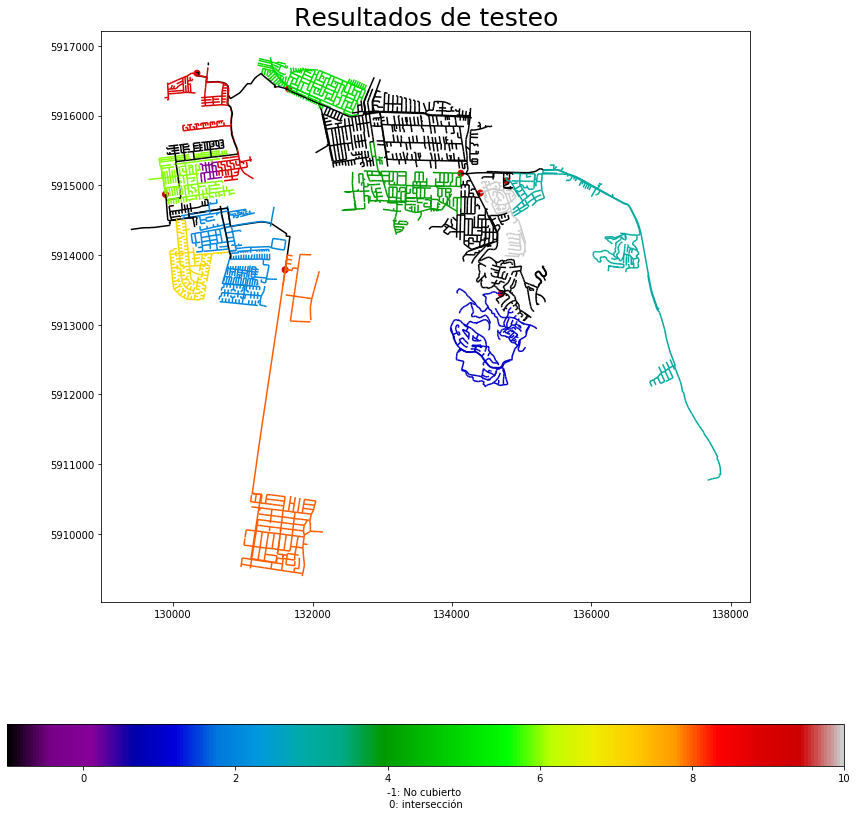

In [104]:
V = [0 for u in range(N)]
max_nodes = len(G.nodes)/10
print(f'Máximo de nodos por ideal: {max_nodes}')
ans = greedyAppW(G, V, N, 10, max_nodes, 200000)
plot_solution(ans, G, N, geometry, _id)

216 216
13


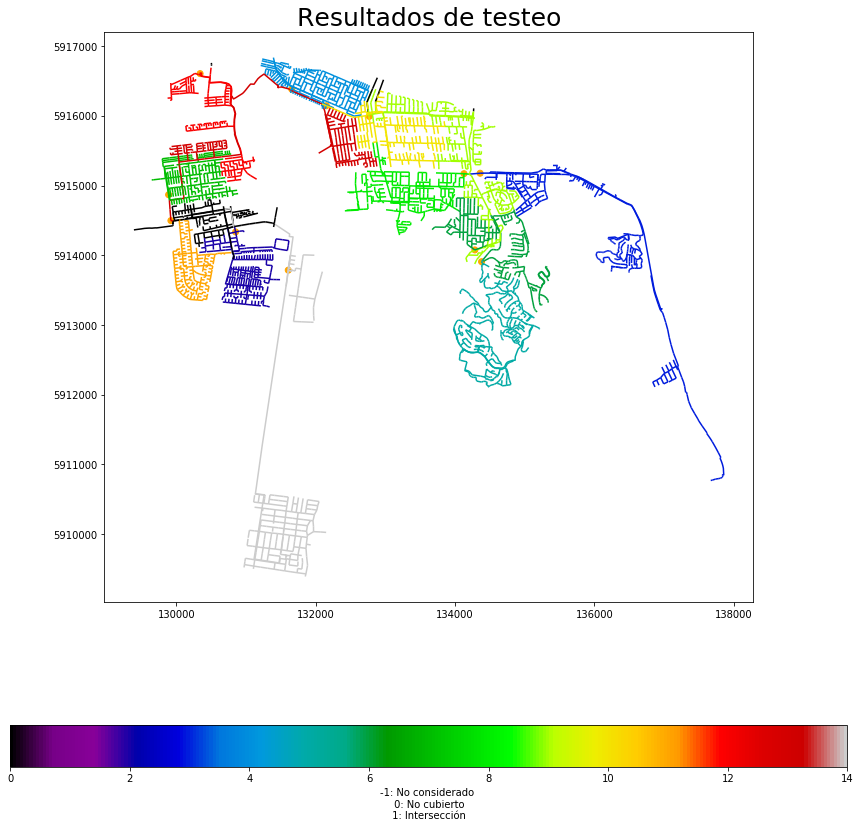

In [105]:
K = 13
nodes_limit = 800
weight_limit = 10e8
G_ = G.copy()
nodos_inicial = len(G_.nodes())
salida = id_[1001544]

V = [0] * N

low = 0; high = N
while low != high:
    mid = (low + high) // 2
    P, sP = greedyAppWeightReduceDynamic(G, V, N, K, mid, 100000000)
    if N - sP < mid:
        high = mid
    else:
        low = mid + 1

low -= 1


sample, sP = greedyAppWeightReduceDynamic(G, V, N, K, low, 100000000)

print(low, N - sP)
print(len(sample))  ## if less than 8 entire graph gets covered with less samples

plot_sample_no_intersections(G, V, N, sample, geometry.copy())

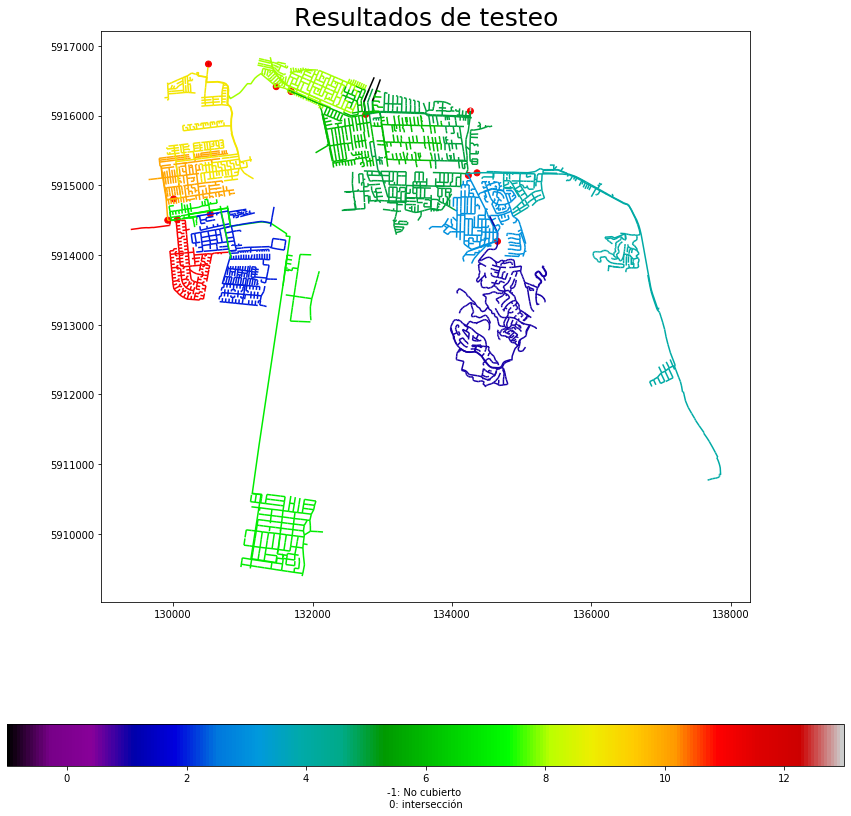

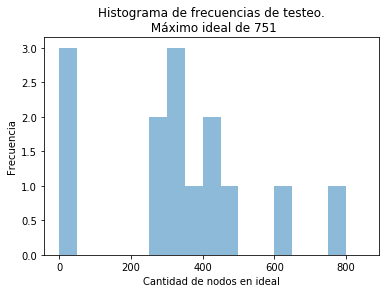

In [106]:
V = [0] * N
ans, sol_dict, sizes, sol_ideals = greedyAppWeightReduceDynamic_partition(G, V, N, 13, 300, 10e7)
plot_from_ideals(sol_ideals, G, N, geometry, _id)
plot_sizes(list(sizes.values()))

# Djikstra para limpiar grafo

La función distance recibe una fila de un GeoPandas DataFrame. Esta construida la función para que el objeto geométrico a evaluar sea un Linestring. A partir de esto busca retornar la distancia entre estos dos puntos. En caso de que no se pueda, asignará un valor arbitratio previamente definido. En nuestro caso se usó la media del resto de las aristas para determinar este valor. Este procedimiento se describe en la celda siguiente.

In [67]:
def distance(row, mean_weights):
  try:
    x_1 = row['geometry'].coords[0][0]
    y_1 = row['geometry'].coords[0][1]
    x_2 = row['geometry'].coords[1][0]
    y_2 = row['geometry'].coords[1][1]
    return (x_1 - x_2)**2 + (y_1 - y_2)**2 
  except:
    return mean_weights

Código utilizado para filtrar aristas que no correspondían al camino más corto hacia la salida del grafo.

In [73]:
# Leemos archivos
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, sep = ';', GEOM_POSSIBLE_NAMES="geometry",KEEP_GEOM_COLUMNS="NO" )
mean_weights = 3590.47

# Instanciamos
G = nx.DiGraph()
for index, row in geometry.iterrows():
  origin = int(row['self'])
  dest = int(row['other'])
  G.add_edge(origin, dest)
  G[origin][dest]['weight'] = distance(row, mean_weights)


# Iteramos por todos los nodos para encontrar su camino más corto hacia la salida
salida = 1001544; paths = {}; ignored = list()
for node in G.nodes:
  try:
    paths[node] = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(G, node, salida, weight = 'weight')[1]
  except:
    ignored.append(node)

In [74]:
weights = 0 
for i in G.edges(data=True):
  weights += i[2]['weight']
mean_weights = weights / (len(G.edges) - len(ignored))
mean_weights

3597.8943638760197

In [75]:
inicial = geometry.shape[0]
dropped = list()
for i, row in geometry.iterrows():
  origin = int(row['self'])
  dest = int(row['other'])
  if origin not in ignored:
     if dest not in paths[origin]:
        geometry = geometry.drop(index = i)
        dropped.append(i)
  # if origin in ignored:
  #   geometry = geometry.drop(index = i)
geometry.to_csv('corrected_dijkstra.csv')
final = geometry.shape[0]
print(f'Se eliminaron {inicial - final} aristas')

Se eliminaron 262 aristas


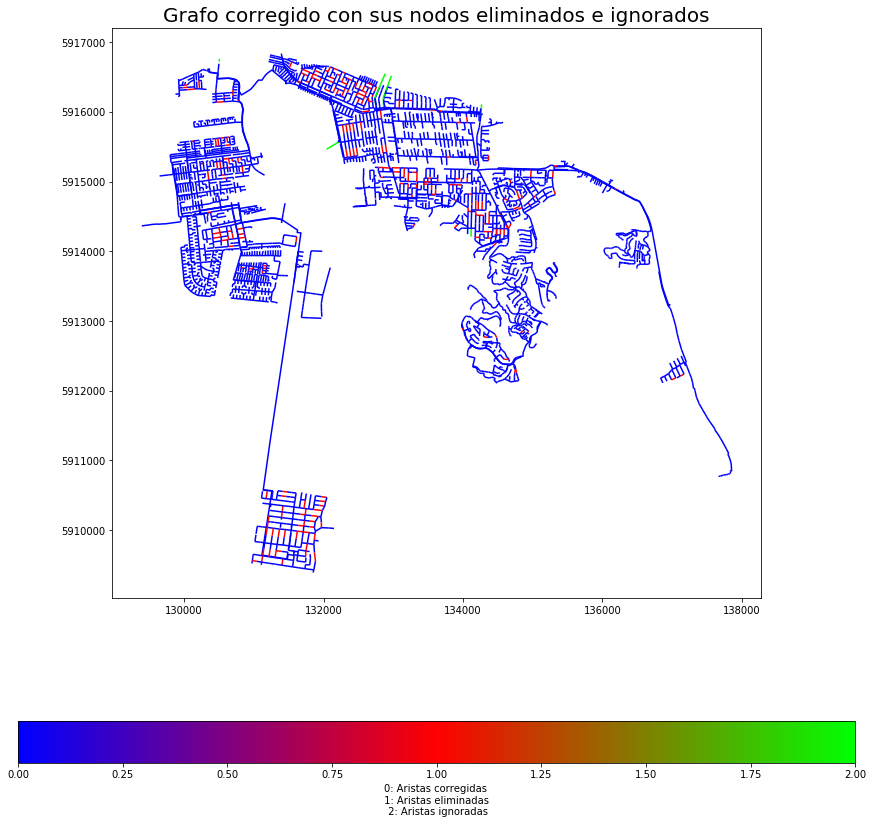

In [76]:
# nodos ignorados
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep = ';')

csv_grafo['color'] = 0

for drop in dropped:
  csv_grafo.at[drop, 'color'] =  1

for ign in ignored:
  csv_grafo.loc[csv_grafo['self'] ==  ign , 'color'] = 2
  csv_grafo.loc[csv_grafo['other'] ==  ign , 'color'] = 2

geometry['color'] = csv_grafo['color'] 


f, ax = plt.subplots(figsize=(15, 15))
ax.set_title(f'Grafo corregido con sus nodos eliminados e ignorados',
  fontsize=20)

ax = geometry.plot(ax = ax, column = 'color',
              figsize=(15, 15),
              legend = True,
              legend_kwds={'label': "0: Aristas corregidas \n 1: Aristas eliminadas \n 2: Aristas ignoradas", 'orientation': "horizontal"},
              cmap = 'brg',)

# Análisis de sensibilidad de soluciones


Se parte instanciando ambos grafos: el original y el corregido. Se definen sus respectivos diccionarios, N y sus grafos.

In [77]:
path_original = 'data/graph_geom_corrected_cycles.csv'
csv_original = pd.read_csv(path_original, sep = ';')
geometry_original = gpd.read_file(path_original, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)


S = set()
for index, row in csv_original.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_o = {}; o_id = {}; l = 0
for u in S:
    id_o[u] = l; o_id[l] = u
    l += 1

G_original = nx.DiGraph()
for index, row in csv_original.iterrows():
    origin = row['self']
    dest = row['other']
    G_original.add_edge(id_o[origin], id_o[dest])
    
N_o = l

W = [0 for u in range(N_o)]
V_o = [0 for u in range(N_o)]

for u in range(N_o):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [78]:
path_arbol = 'data/corrected_dijkstra.csv'
csv_arbol = pd.read_csv(path_arbol)
geometry_arbol = gpd.read_file(path_arbol, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO").drop(["field_1"], axis=1)

S = set()
for index, row in csv_arbol.iterrows():
    origin = row['self']
    dest = row['other']
    S.add(origin)
    S.add(dest)

S = list(S)
id_a = {}; a_id = {}; l = 0
for u in S:
    id_a[u] = l; a_id[l] = u
    l += 1

G_arbol = nx.DiGraph()
for index, row in csv_arbol.iterrows():
    origin = row['self']
    dest = row['other']
    G_arbol.add_edge(id_a[origin], id_a[dest])
    
N_a = l

W_a = [0 for u in range(N_a)]
V_a = [0 for u in range(N_a)]

for u in range(N_a):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W_a[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Se consideran las primeras 5 etapas. Lo que se hace es para cada etapa se obtienen las soluciones dentro del grafo original. Luego se compara el tamano de los ideales inducidos dentro de los nodos no visitados en ambos grafos y se registra su diferencia. Se calcula su promedio de diferencia porcentual. Además, se filtran los valores que se pasan sobre el 50% del valor del ideal ya que se consideran como datos anómalos. Se comenta procedimiento para la primera etapa. Las siguientes son análogas.

In [79]:
k_1 = 10; k_2 = 3 
# Diferencia real
D1 = list(); D2 = list(); D3 = list(); D4 = list(); D5 = list()
# Cantidad de valores filtrados por etapa
S1 = 0; S2 = 0; S3 = 0; S4 =0; S5 = 0
V_o = [0 for u in range(N_o)]; V_a = [0 for u in range(N_a)]

# DESCOMENTAR PARA HACER EL MISMO ANÁLISIS PERO OBTENIENDO LAS SOLUCIONES DESDE EL GRAFO CORREGIDO
# G_arbol, G_original = G_original, G_arbol
# V_o, V_a = V_a, V_o
# N_o, N_a = N_a, N_o
# o_id, a_id = a_id, o_id
# id_a, id_o = id_o, id_a

# PRIMERA ETAPA
# Primero obtenemos la solución
ans_o, sol_dict_o, sizes_o, sol_ideals_o = greedyAppWeightReduceDynamic_partition(G_original, V_o, N_o, k_1, 400, 10e7)
# Para cada elemento de la solución definimos el ideal correspondiente dentro del grafo corregido.
for sol_o, ideal_o in sol_ideals_o.items():
        sol_a = id_a[o_id[sol_o]]
        size_o = get_size(G_original, V_o, N_o, sol_o)
        # Calculamos la diferencia del tamano de los ideales en ambos grafos.
        d1 = abs(get_size(G_arbol, V_a, N_a, sol_a) - size_o)
        D1.append(d1)
        if size_o > 0:
            # Si cumple el filtro lo agregamos a la lista que registra las diferencias  relativas
            if d1 < size_o * 0.5 :
                dif_1.append(d1 / size_o)
            else:
            # En caso contrario registramos que lo hemos ignorado
                S1 += 1
        
        
        # SEGUNDA ETAPA
        # Agregamos el paso de volver a calcular la lista de visitados para trabajar solamente dentro de este ideal
        V_o_2 = [0 if i in ideal_o else 1 for i in range(N_o)]
        ideal_a = [id_a[o_id[i]] for i in ideal_o] 
        V_a_2 = [0 if i in ideal_a else 1 for i in range(N_a)] 
        ans_o_2, sol_dict_o_2, sizes_o_2, sol_ideals_o_2 = greedyAppWeightReduceDynamic_partition(G_original, V_o_2, N_o, k_2, 75, 10e7)
        for sol_o, ideal_o in sol_ideals_o_2.items():
            sol_a = id_a[o_id[sol_o]]
            size_o = get_size(G_original, V_o_2, N_o, sol_o)
            d2 = abs(get_size(G_arbol, V_a_2, N_a, sol_a) - size_o)
            D2.append(d2)
            if size_o > 0:
                if d2 < size_o * 0.5 :
                    dif_2.append(d2 / size_o)
                else:
                    S2 += 1
            
            # TERCERA ETAPA
            V_o_3 = [0 if i in ideal_o else 1 for i in range(N_o)]
            ideal_a = [id_a[o_id[i]] for i in ideal_o] 
            V_a_3 = [0 if i in ideal_a else 1 for i in range(N_a)] 
            ans_o_3, sol_dict_o_3, sizes_o_3, sol_ideals_o_3 = greedyAppWeightReduceDynamic_partition(G_original, V_o_3, N_o, k_2 - 1, 20, 10e7)
            for sol_o, ideal_o in sol_ideals_o_3.items():
                sol_a = id_a[o_id[sol_o]]
                size_o = get_size(G_original, V_o_3, N_o, sol_o)
                d3 = abs(get_size(G_arbol, V_a_3, N_a, sol_a) - size_o)
                D3.append(d3)
                if size_o > 0:
                    if d3 < size_o * 0.5:
                        dif_3.append(d3 / size_o)
                    else:
                        S3 += 1
                
                # CUARTA ETAPA
                V_o_4 = [0 if i in ideal_o else 1 for i in range(N_o)]
                ideal_a = [id_a[o_id[i]] for i in ideal_o] 
                V_a_4 = [0 if i in ideal_a else 1 for i in range(N_a)] 
                ans_o_4, sol_dict_o_4, sizes_o_4, sol_ideals_o_4 = greedyAppWeightReduceDynamic_partition(G_original, V_o_4, N_o, k_2 - 1, 10, 10e7)
                for sol_o, ideal_o in sol_ideals_o_4.items():
                    sol_a = id_a[o_id[sol_o]]
                    size_o = get_size(G_original, V_o_4, N_o, sol_o)
                    d4 = abs(get_size(G_arbol, V_a_4, N_a, sol_a) - size_o)
                    D4.append(d4)
                    if size_o > 0:
                        if d4 < size_o * 0.5:
                            dif_4.append(d4 / size_o)
                        else:
                            S4 += 1
    
                    
                    # QUINTA ETAPA
                    V_o_5 = [0 if i in ideal_o else 1 for i in range(N_o)]
                    ideal_a = [id_a[o_id[i]] for i in ideal_o] 
                    V_a_5 = [0 if i in ideal_a else 1 for i in range(N_a)] 
                    ans_o_5, sol_dict_o_5, sizes_o_5, sol_ideals_o_5 = greedyAppWeightReduceDynamic_partition(G_original, V_o_5, N_o, k_2 - 1, 2, 10e7)
                    for sol_o, ideal_o in sol_ideals_o_5.items():
                        sol_a = id_a[o_id[sol_o]]
                        size_o = get_size(G_original, V_o_5, N_o, sol_o)
                        d5 = abs(get_size(G_arbol, V_a_5, N_a, sol_a) - size_o)
                        D5.append(d5)
                        if size_o > 0:
                            if d5 < size_o * 0.5:
                                dif_5.append(d5 / size_o)
                            else:
                                S5 += 1
            

breaking ideal


In [80]:
print(f'ETAPA 1 -> Ignorados: {S1}, promedio: {round(sum(dif_1) / len(dif_1), 4)*100}%')
print(f'ETAPA 2 -> Ignorados: {S2}, promedio: {round(sum(dif_2) / len(dif_2), 4)*100}%')
print(f'ETAPA 3 -> Ignorados: {S3}, promedio: {round(sum(dif_3) / len(dif_3), 4)*100}%')
print(f'ETAPA 4 -> Ignorados: {S4}, promedio: {round(sum(dif_4) / len(dif_4), 4)*100}%')
print(f'ETAPA 5 -> Ignorados: {S5}, promedio: {round(sum(dif_5) / len(dif_5), 4)*100}%')

ETAPA 1 -> Ignorados: 3, promedio: 0.61%
ETAPA 2 -> Ignorados: 1, promedio: 3.71%
ETAPA 3 -> Ignorados: 3, promedio: 5.99%
ETAPA 4 -> Ignorados: 9, promedio: 6.4%
ETAPA 5 -> Ignorados: 9, promedio: 1.26%
